In [81]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import json
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from random import *
from math import log
import copy
pd.set_option('display.max_columns', None)
from pandas.io.json import json_normalize

from scipy.stats.stats import pearsonr   
%matplotlib inline

In [2]:
# load business and user data
with open('dataset/business.json') as f:
    business_data = [json.loads(line) for line in f]
with open('dataset/user.json') as f:
    user_data = [json.loads(line) for line in f]  

In [3]:
# preprocessed file with reviews only for restaurants
with open('dataset/restaurant_reviews.json', encoding = 'utf-8') as f:
    review_data = [json.loads(line) for line in f]

In [4]:
# convert array to list (how preprocessed file was formatted)
restaurant_reviews = review_data[0]

In [5]:
# pull just restaurant data from business data
restaurant_data = [x for x in business_data if 'Restaurants' in x['categories']]

In [6]:
del review_data
del business_data

In [7]:
# pandas dataframe of restaurant data
restaurant_df = json_normalize(restaurant_data)

In [28]:
# take 100000 reviews as sample
data_array = (np.random.choice(restaurant_reviews, size = 100000))
data_set = list(data_array)

In [29]:
# find all categories for one-hot encoding purposes
from collections import Counter
all_categories = []
for r in restaurant_data:
    if 'Restaurants' in r['categories']:
        for c in r['categories']:
            all_categories.append(c)

In [30]:
# take 150 most popular categories
counts = list (Counter(all_categories).items())
counts.sort(key=lambda x: x[1], reverse = True)
most_popular = [x[0] for x in counts[:150]]

In [31]:
# create restaurant and user dictionaries for easy lookup
restaurant_dict = {}
for item in restaurant_data:
    restaurant_id = item['business_id']
    restaurant_dict[restaurant_id] = item

user_dict = {}
for item in user_data:
    user_id = item['user_id']
    user_dict[user_id] = item

In [32]:
# make copy of the reviews array
expanded_reviews = copy.deepcopy(data_array)

In [33]:
# add business and user info
for review in expanded_reviews:
    #print (review)
    restaurant = review['business_id']
    user = review['user_id']
    restaurant_info = restaurant_dict[restaurant]
    #print (restaurant_info)
    user_info = user_dict[user]
    for attribute in restaurant_info:
        #print (attribute)
        if attribute not in ['is_open', 'latitude','longitude','name','business_id',
                             'neighborhood','address','city','postal_code','hours']:
            if attribute == 'categories':
                for c in most_popular:
                    if c in restaurant_info[attribute]:
                        review['R_' +  c] = 1
                    else:
                        review['R_' +  c] = 0
            else:         
                review['R_' + attribute] = restaurant_info[attribute]
    for attribute in user_info:
        if attribute not in ['user_id','name']:   
            if attribute == 'friends':
                review['U_friends'] = len(user_info[attribute])
            elif attribute == 'yelping_since':
                review['U_yelping_since'] = user_info[attribute][:4]
            elif attribute == 'elite':
                if user_info[attribute]:
                    review['U_elite'] = True
                else:
                    review['U_elite'] = False        
            else:
                review['U_' + attribute] = user_info[attribute] 

In [34]:
# create pandas dataframe
flatframe = json_normalize(expanded_reviews)
flatframe = flatframe.drop(['text','useful','funny','cool','date'], axis=1)

In [35]:
# change user since
flatframe['U_years_yelping'] = [2015 - int(x) for x in flatframe['U_yelping_since']]
flatframe.drop(['U_yelping_since'],axis = 1, inplace = True)

In [36]:
# drop ids
flatframe_wids = flatframe.drop(['business_id', 'review_id', 'user_id'], axis = 1)

In [37]:
#one hot encode
flatframe_wids = pd.get_dummies(flatframe_wids, columns = ['R_state', 
                                                    'R_attributes.Alcohol', 'R_attributes.AgesAllowed', 'R_attributes.RestaurantsAttire',
                                                    'R_attributes.RestaurantsPriceRange2','R_attributes.Smoking',
                                                    'R_attributes.WiFi', 'R_attributes.NoiseLevel','R_attributes.BYOBCorkage'])

In [38]:
# drop column if more than half of a column is nan
nan_count = {}
for column in flatframe_wids:
     nan_count[column] = flatframe_wids[column].isnull().sum()

nan_sorted = sorted(nan_count.items(), key=lambda x: x[1], reverse = True) 
drop_nans = [x[0] for x in nan_sorted if x[1] > 50000]

In [39]:
# drop some nans and fill some nans
flatframe_wids = flatframe_wids.drop(drop_nans, axis = 1)
flatframe_wids = flatframe_wids.fillna(flatframe_wids.mean())

In [40]:
# train test split
msk = np.random.rand(len(flatframe_wids)) < 0.5
data_train = flatframe_wids[msk]
data_test = flatframe_wids[~msk]

In [41]:
# make pandas dataframe for user data
user_df = json_normalize(user_data)

In [42]:
# train test split including business ids and user ids
data_train_temp = flatframe[msk]
data_test_temp = flatframe[~msk]

In [43]:
# global user average
users = data_train_temp.user_id.unique()
user_total = user_df[user_df['user_id'].isin(users)]['average_stars']
global_user_average = sum(user_total)/len(user_total)
print (global_user_average)

3.73744539253


In [44]:
# global restaurant average
restaurants = data_train_temp.business_id.unique()
restaurant_total = restaurant_df[restaurant_df['business_id'].isin(restaurants)]['stars']
global_restaurant_average = sum(restaurant_total)/len(restaurant_total)
print (global_restaurant_average)

3.5691960774


In [45]:
# global review average
global_review_average = data_train['stars'].mean()
print (global_review_average)

3.7128174365126974


In [46]:
# user biases
user_deviations = {}
for item in user_data:
    user_id = item['user_id']
    user_deviations[user_id] = item['average_stars'] - global_user_average

In [47]:
# restaurant biases
restaurant_deviations = {}
for item in restaurant_data:
    rest_id = item['business_id']
    restaurant_deviations[rest_id] = item['stars'] - global_restaurant_average

In [51]:
# creating xy variables
Xtrain = data_train.drop(['stars'], axis = 1)
ytrain = data_train['stars']
Xtest = data_test.drop(['stars'], axis = 1)
ytest = data_test['stars']

In [52]:
def baseline(user_id, business_id):
    pred = global_review_average + user_deviations[user_id] + restaurant_deviations[business_id]
    return int(round(pred))

In [53]:
# predictions
base_pred = [baseline(x,y) for x,y in zip(data_train_temp['user_id'],data_train_temp['business_id'])]
base_pred_test = [baseline(x,y) for x,y in zip(data_test_temp['user_id'],data_test_temp['business_id'])]

In [54]:
print ("The accuracy score of the baseline model on the train set is {}"
       .format(metrics.accuracy_score(ytrain, base_pred)))
print ("The accuracy score of the baseline model on the test set is {}"
       .format(metrics.accuracy_score(ytest, base_pred_test)))

The accuracy score of the baseline model on the train set is 0.3932413517296541
The accuracy score of the baseline model on the test set is 0.38885777155431084


In [100]:
# calculate averages
pred_df_train = pd.DataFrame({'y' : ytrain, 'ypred' : base_pred})
pred_df_test = pd.DataFrame({'y' : ytest, 'ypred' : base_pred_test})

base_pred_avg = []
base_pred_test_avg = []
for i in [1, 2, 3, 4, 5]:
    base_pred_avg.append(pred_df_train[pred_df_train['y'] == i]['ypred'].mean())
    base_pred_test_avg.append(pred_df_test[pred_df_test['y'] == i]['ypred'].mean())

## Part 2: Create a Regularized Regression

Now we are interested in building regularized regressions from our baseline model. In do so we are changing our regression fit from 

$$ \hat{Y}_{um} = \hat{\mu} + \hat{\theta}_{u} + \hat{\gamma}_m $$

to 

$$ \hat{Y}_{um} = \hat{\mu} + \bar{\theta}I_u + \hat{\gamma} I_m $$

where $I_u$ and $I_m$ are the indicator variables for the u-th user and the m-th restaurant in the feature matrix. We ended up building both Lasso and Ridge regressions to see if there were any improvements. 

### Linear Model

In [55]:
model = LinearRegression()
model.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

We used a linear model rather than a logistic model as although the y-varaible was categorical (1, 2, 3, 4, or 5), it was ordinal.

In [56]:
ypred = model.predict(Xtrain)
ypred_test = model.predict(Xtest)
predround = [int(round(x)) for x in ypred]
print ("The accuracy score of the linear model on the train set is {}"
       .format(metrics.accuracy_score(ytrain, predround)))
predround_test = [int(round(x)) for x in ypred_test]
print ("The accuracy score of the linear model on the test set is {}"
       .format(metrics.accuracy_score(ytest, predround_test)))

The accuracy score of the linear model on the train set is 0.38662267546490703
The accuracy score of the linear model on the test set is 0.3810962192438488


Here, we round the predictions from the model to the nearest integer to fit the predictions in the categories (1, 2, 3, 4, or 5).

### Lasso CV

In [60]:
model_lasso = LassoCV().fit(Xtrain, ytrain)

In [61]:
lasso_ypred = model_lasso.predict(Xtrain)
lasso_ypred_round = [int(round(x)) for x in lasso_ypred]
lasso_ypred_test = model_lasso.predict(Xtest)
lasso_ypred_test_round = [int(round(x)) for x in lasso_ypred_test]

In [62]:
print ("The accuracy score of the lasso model on the train set is {}"
       .format(metrics.accuracy_score(ytrain, lasso_ypred_round)))
print ("The accuracy score of the lasso model on the test set is {}"
       .format(metrics.accuracy_score(ytest, lasso_ypred_test_round)))

The accuracy score of the lasso model on the train set is 0.3672265546890622
The accuracy score of the lasso model on the test set is 0.36415283056611325


### Ridge CV

In [57]:
model_ridge = RidgeCV().fit(Xtrain, ytrain)

In [58]:
ridge_ypred = model_ridge.predict(Xtrain)
ridge_ypred_round = [int(round(x)) for x in ridge_ypred]
ridge_ypred_test = model_ridge.predict(Xtest)
ridge_ypred_test_round = [int(round(x)) for x in ridge_ypred_test]

In [59]:

print ("The accuracy score of the ridge model on the train set is {}"
       .format(metrics.accuracy_score(ytrain, ridge_ypred_round)))
print ("The accuracy score of the ridge model on the test set is {}"
       .format(metrics.accuracy_score(ytest, ridge_ypred_test_round)))

The accuracy score of the ridge model on the train set is 0.3862627474505099
The accuracy score of the ridge model on the test set is 0.38135627125425087


We will be using the regularized linear regression using the ridge method as it performed better than the lasso method for accuracy score (and very similarly to the naive linear regression).

In [108]:
# calculate averages
pred_df_train = pd.DataFrame({'y' : ytrain, 'ypred' : ridge_ypred_round})
pred_df_test = pd.DataFrame({'y' : ytest, 'ypred' : ridge_ypred_test_round})

ridge_pred_avg = []
ridge_pred_test_avg = []
for i in [1, 2, 3, 4, 5]:
    ridge_pred_avg.append(pred_df_train[pred_df_train['y'] == i]['ypred'].mean())
    ridge_pred_test_avg.append(pred_df_test[pred_df_test['y'] == i]['ypred'].mean())

(1, 5)

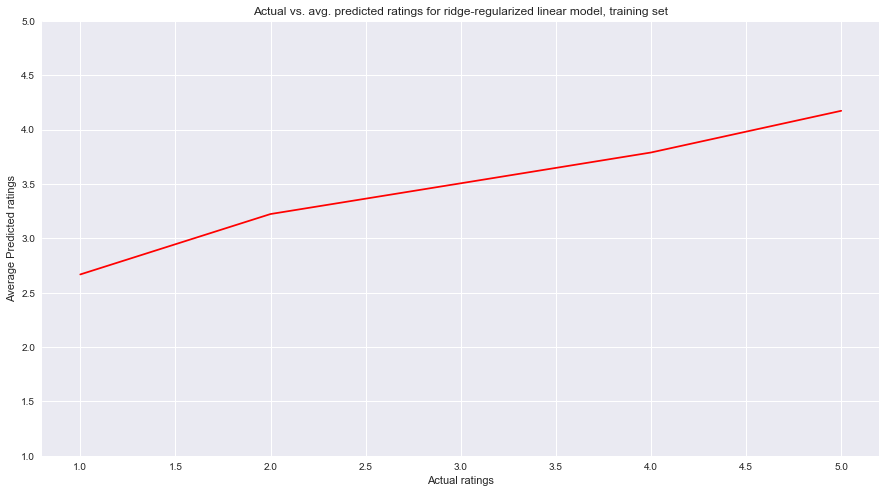

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot([1, 2, 3, 4, 5], ridge_pred_avg, color='red')

ax.set_xlabel('Actual ratings')
ax.set_ylabel('Average Predicted ratings')
ax.set_title('Actual vs. avg. predicted ratings for ridge-regularized linear model, training set')
ax.set_ylim((1,5))

(1, 5)

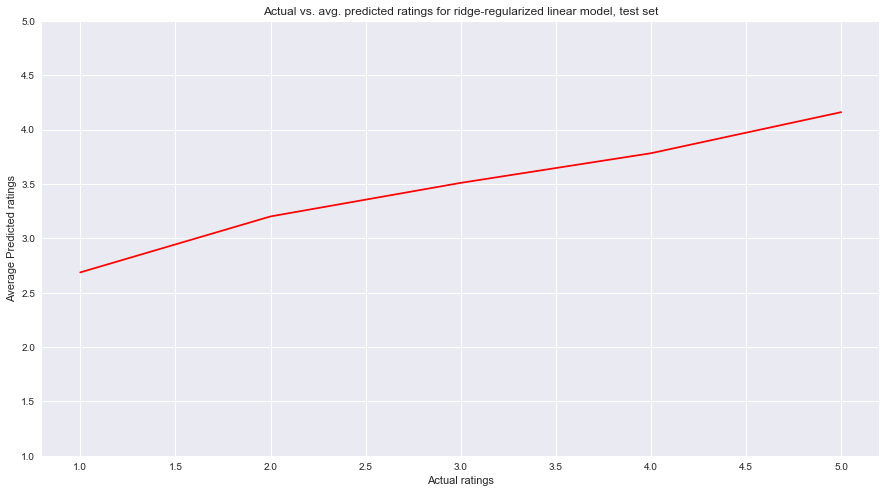

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot([1, 2, 3, 4, 5], ridge_pred_test_avg, color='red')

ax.set_xlabel('Actual ratings')
ax.set_ylabel('Average Predicted ratings')
ax.set_title('Actual vs. avg. predicted ratings for ridge-regularized linear model, test set')
ax.set_ylim((1,5))

On average, our predictions for both the training and the test set follow the increasing trend of actual ratings but overestimate for lower ratings and underestimate for higher ratings.